Based on:

License: BSD
Author: Sasank Chilamkurthy
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

...with minor modifications

In [1]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

plt.ion()

In [2]:
!ls ../..
DATA_DIR = '../../data/hymenoptera_data'
IMG_MEANS = [0.485, 0.456, 0.406]
IMG_SDS = [0.229, 0.224, 0.225]

data      tutorials


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEANS, IMG_SDS)]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEANS, IMG_SDS)])}

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), 
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [5]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMG_MEANS)
    std = np.array(IMG_SDS)
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

In [9]:
inputs, classes = next(iter(dataloaders['train']))

In [10]:
out = torchvision.utils.make_grid(inputs)

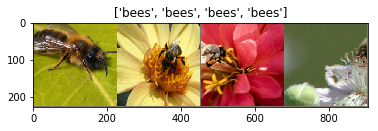

In [11]:
imshow(out, title=[class_names[x] for x in classes])

# Training the Model

In [12]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 25)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # set to training mode
            else:
                model.eval()  # ''  ''  eval    ''
            running_loss = 0.
            running_correct = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct.double() / dataset_sizes[phase]
            print('  {} Loss: {:.4f}\tAcc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_weights)
    return model

# Visualizing Model Performance

In [13]:
def visualize_model(model, n_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(n_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == n_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was.training)

# Fine Tuning

In [14]:
ETA = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7 # Update scheduler
GAMMA = 0.1   # factor (= 1 - lambda)
EPOCHS = 25

In [15]:
model_ft = models.resnet18(pretrained=True)
n_filters = model_ft.fc.in_features
model_ft.fc = nn.Linear(n_filters, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=ETA, momentum=MOMENTUM)

# reduce ETA by 10% every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

In [16]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, epochs=EPOCHS)

Epoch 1/25
-------------------------
  train Loss: 0.6410	Acc: 0.6926
  val Loss: 0.2067	Acc: 0.9281

Epoch 2/25
-------------------------
  train Loss: 0.2688	Acc: 0.9057
  val Loss: 0.3251	Acc: 0.8824

Epoch 3/25
-------------------------
  train Loss: 0.6543	Acc: 0.7623
  val Loss: 0.2805	Acc: 0.8889

Epoch 4/25
-------------------------
  train Loss: 0.5681	Acc: 0.7705
  val Loss: 0.3297	Acc: 0.8758

Epoch 5/25
-------------------------
  train Loss: 0.4979	Acc: 0.8033
  val Loss: 0.2759	Acc: 0.9020

Epoch 6/25
-------------------------
  train Loss: 0.5962	Acc: 0.7664
  val Loss: 0.2741	Acc: 0.9216

Epoch 7/25
-------------------------
  train Loss: 0.4603	Acc: 0.7992
  val Loss: 0.2465	Acc: 0.9150

Epoch 8/25
-------------------------
  train Loss: 0.5312	Acc: 0.7951
  val Loss: 0.2315	Acc: 0.9150

Epoch 9/25
-------------------------
  train Loss: 0.2820	Acc: 0.8730
  val Loss: 0.1943	Acc: 0.9281

Epoch 10/25
-------------------------
  train Loss: 0.3502	Acc: 0.8607
  val Loss:

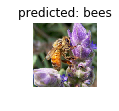

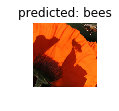

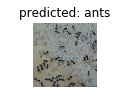

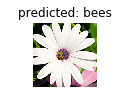

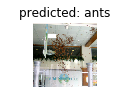

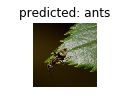

In [17]:
visualize_model(model_ft)

# As Fixed Feature Extractor

In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
n_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(n_features, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(
    model_conv.fc.parameters(), lr=ETA, momentum=MOMENTUM)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_conv, step_size=STEP_SIZE, gamma=GAMMA)

In [22]:
model_conv = train_model(model_conv, 
                         criterion, 
                         optimizer_conv, 
                         exp_lr_scheduler, 
                         epochs=EPOCHS)

Epoch 1/25
-------------------------
  train Loss: 0.7248	Acc: 0.5943
  val Loss: 0.2755	Acc: 0.8824

Epoch 2/25
-------------------------
  train Loss: 0.3461	Acc: 0.8730
  val Loss: 0.2584	Acc: 0.8954

Epoch 3/25
-------------------------
  train Loss: 0.6762	Acc: 0.7295
  val Loss: 0.4229	Acc: 0.8301

Epoch 4/25
-------------------------
  train Loss: 0.5949	Acc: 0.7418
  val Loss: 0.2668	Acc: 0.8889

Epoch 5/25
-------------------------
  train Loss: 0.7490	Acc: 0.7090
  val Loss: 0.2104	Acc: 0.9346

Epoch 6/25
-------------------------
  train Loss: 0.4297	Acc: 0.8156
  val Loss: 0.1756	Acc: 0.9477

Epoch 7/25
-------------------------
  train Loss: 0.4238	Acc: 0.8156
  val Loss: 0.4810	Acc: 0.8105

Epoch 8/25
-------------------------
  train Loss: 0.4386	Acc: 0.8197
  val Loss: 0.1889	Acc: 0.9412

Epoch 9/25
-------------------------
  train Loss: 0.3646	Acc: 0.8279
  val Loss: 0.2389	Acc: 0.9216

Epoch 10/25
-------------------------
  train Loss: 0.4533	Acc: 0.8443
  val Loss:

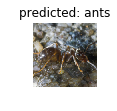

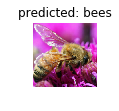

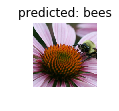

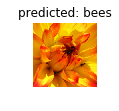

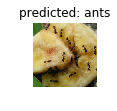

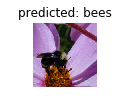

In [23]:
visualize_model(model_conv)